In [83]:
import findspark
findspark.init('C:\\Users\\vivia\\spark-3.0.0-preview2-bin-hadoop2.7')
import pyspark
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SQLContext
import re
import numpy as np
import pandas as pd
from pprint import pprint
import spacy
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.types import ArrayType,StringType,FloatType
from spacy.tokens import Token
from pyspark.ml.feature import CountVectorizer , IDF

sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)
conf = SparkConf()
conf.set("spark.driver.memory", "35g")
conf.set("spark.executor.memory", "50g")
conf.set("spark.memory.fraction","0.1")
conf.set("spark.executor.heartbeatInterval",'3600s')
conf.set("spark.network.timeout", "20000s")
conf.set("spark.driver.maxResultSize","25g")
#conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")
#conf.set("spark.cleaner.periodicGC.interval","15min")
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("NLP Project") \
    .getOrCreate()


In [84]:
filepath = "C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics\\"

In [165]:
sc.stop()

In [109]:
#import filtered dataset with ads removed from 
df = spark.read\
  .option("multiLine", "true")\
  .option("header", "true")\
  .option("escape", "\"")\
  .csv("C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Data\\all-the-news-2016-2020.csv")


# Preprocessing Text

- remove null values from essential fields
- remove articles that are too short/long to prevent noise

In [154]:
from pyspark.sql.functions import *
df = df.withColumn('date', df['date'].cast('date')).select('*')
df = df.select('_c0','date',year('date').alias('year'),month('date').alias('month'),dayofmonth('date').alias('day'),'title',regexp_replace('article', "\n", "").alias('article'),'publication')
df_nonull = df.na.drop()
df_art_len = df_nonull.select('*',size(split('article',' ')).alias('article length'))

min_length = 77
max_length = 800

#df_filtered = df_art_len.select('*').where((df_art_len['article length']>min_length) & (df_art_len['article length']<max_length) & (df_art_len['year']>=2018))
df_filtered = df_art_len.select('*').where((df_art_len['article length']>min_length) & (df_art_len['article length']<max_length) & (df_art_len['year']<2017))

df_lower = df_filtered.select('_c0','date','article', (lower('article')).alias('lower_text'))
#df_lower.show(5)


- tokenize sentences
- remove publications details and advertisements 

In [149]:
import nltk

sent_udf = udf(lambda row: nltk.sent_tokenize(str(row)),ArrayType(StringType()))
#makelist_udf = udf(lambda x: x,ArrayType(StringType()))
df_sent = df_lower.withColumn('sent_tokens',sent_udf(col('lower_text')))\
          .select('_c0','date','article','sent_tokens')
          #.withColumn('sent_tokens',makelist_udf('col'))\
        
df_sent_explode = df_sent.select('_c0','date',explode('sent_tokens').alias('sent_explode')).where(col('sent_explode').isNotNull()).groupBy(['_c0','date','sent_explode']).count()
df_sent_ordered = df_sent_explode.repartition(4).orderBy('count',ascending=False)

df_1 = df_sent_ordered.select('_c0','date','sent_explode',length('sent_explode').alias('sent_length'),'count').where((col('sent_length')>=3) & (col('count')<=2 ))
df_2 = df_1.groupBy(['_c0','date']).agg(collect_list("sent_explode").alias('list_sent'))

makesent_udf = udf(lambda s: ' '.join(s))
df_pre = df_2.withColumn('article_sents',makesent_udf(col('list_sent'))).select('_c0','date','article_sents')


In [157]:
df_pre=df_pre.repartition(2)
df_pre.write\
.option("header",'true')\
.csv("df_pre_short_2016.csv")

In [85]:
df_pre = spark.read\
    .option("header",'true')\
    .option("multiLine", "true")\
    .option("escape", "\"")\
    .csv("df_pre_short.csv")
df_pre=df_pre.repartition(2)
df_pre.rdd.getNumPartitions()

2

In [86]:
#remove punctuation
df_nopunc = df_pre.select('*', ((regexp_replace('article_sents', '[^a-zA-Z\s]', "")).alias('no_punc_text')))

nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
nlp.add_pipe(nlp.create_pipe('sentencizer'))

#only keep nouns, verbs, adjectives
pos_udf = udf(lambda art: [token.lemma_ for token in nlp(art) if token.pos_ in ['NOUN','VERB','ADJ','PROPN ']],ArrayType(StringType()))
df_filt = df_nopunc.select('*').withColumn('filt_pos',pos_udf(col('no_punc_text'))).select('_c0','date','filt_pos')

#remove stop words
stop_remover = StopWordsRemover(inputCol='filt_pos', outputCol='tokens_nostop')
df_nostop = stop_remover.transform(df_filt).select('_c0','date','tokens_nostop')


## Change this number to update which run:


#### df_6 is the same as df_store[6]
#### Output/dataframe names will change dynamically with df_num
#### Purpose is to be able to run the same code for multiple datasets

In [87]:
df_num = 6

In [88]:
#dataset of times series where value is outside 90% CI of forecast
filtered_time_series = spark.read\
    .option("header",'true')\
    .option("escape", "\"")\
    .csv(filepath+"filtered_dates{df_num}_0.75year.csv".format(df_num=df_num))

- filter for peak days
- get vocabulary size for count vectorizer

In [89]:
dates_forlda = filtered_time_series.select("Date").rdd.flatMap(lambda x:x).collect()
df_forlda = df_nostop.select('*').where(col('date').isin(dates_forlda))

vocabSize = df_forlda.select(explode("tokens_nostop")).distinct().count()

### Prepare data in format for LDA model
- create term frequency matrix (TF)
- create term frequency-inverse document frequency matrix (TF-IDF)

In [90]:
#LDA using pyspark

#TF
cv = CountVectorizer(inputCol="tokens_nostop", outputCol="raw_features", vocabSize=vocabSize, minDF=10.0)
cvmodel = cv.fit(df_forlda)
result_cv = cvmodel.transform(df_forlda)

# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 


### Create LDA model

- create topic model to fit peak day articles
- pick number of topics and number of iterations. The number of iterations is smaller here due to limitations in processing power

In [91]:
from pyspark.ml.clustering import LDA
num_topics = 100
max_iterations = 50
#lda = LDA.train(result_tfidf[['_c0','features']].rdd.map(list), k=num_topics, maxIterations=max_iterations,seed=1)
lda = LDA(k=num_topics, maxIter=max_iterations,seed=1)
lda_model = lda.fit(result_tfidf[['_c0','date','features']])

- print top 10 words associated with each topic for the 100 topics

In [92]:
wordNumbers = 10  
topicIndices = sc.parallelize(lda_model.describeTopics(maxTermsPerTopic = wordNumbers).rdd.collect())
#topicIndices = sc.parallelize(df_topics.rdd.collect())
vocabArray = cvmodel.vocabulary

def topic_render(topic):
    terms = topic
    print(terms)
    result = []
    for i in range(wordNumbers):
        term = vocabArray[terms[i]]
        result.append(term)
    return result

topics_final = topicIndices.map(lambda topic: topic_render(topic[1])).collect()

for topic in range(len(topics_final)):
    print ("Topic" + str(topic) + ":")
    for term in topics_final[topic]:
        print (term)
    print ('\n')

Topic0:
royal
studio
yellow
afghan
palace
queen
album
film
perry
peace


Topic1:
brazilian
iron
brazil
procedure
dam
commission
ore
vale
auditor
mining


Topic2:
water
weather
temperature
rain
storm
degree
flood
warm
wind
snow


Topic3:
vote
labour
map
district
liberal
party
senator
race
conservative
justice


Topic4:
collin
dressed
flore
spa
exquisite
definite
breakthrough
merge
tense
sanitary


Topic5:
cosmetic
wood
charger
jordyn
sunday
nhs
emotion
mend
playlist
kylie


Topic6:
whale
college
sport
student
insider
dog
restaurant
opioid
meat
athlete


Topic7:
immigrant
migrant
religious
state
law
muslim
immigration
constitution
citizenship
minority


Topic8:
ice
flame
salesforce
moral
contract
philanthropy
chef
calgary
courtesy
compass


Topic9:
sex
balloon
confederate
spiderman
memorial
endgame
trafficker
trafficking
blockbuster
monument


Topic10:
egg
food
coffee
drink
salt
lake
cook
fish
tip
chocolate


Topic11:
satellite
syrian
object
turkish
gate
roku
alien
scientist
prize
idlib


In [93]:
#export topics into csv file
csv_lines = []
for topic in topics_final:
    csv_lines.append(",".join(topic))

f = open(filepath+"topic_list{df_num}_100topics.csv".format(df_num=df_num), "w")
f.write("\n".join(csv_lines))
f.close()

In [43]:
df_ts = spark.read\
    .option("header",'true')\
    .csv(filepath+"df_train{df_num}_0.75year_2016.csv".format(df_num=df_num))

In [44]:
max_date = df_ts.select(max('date')).collect()[0][0]
df_combined = df_nostop.select('*').where(col('date') <= max_date)
df_combined_temp= df_combined.select('date',explode("tokens_nostop").alias("tokens_explode"))
df_combined_bydate= df_combined_temp.groupBy('date').agg(collect_list("tokens_explode").alias('tokens_nostop'))


result_cv_all = cvmodel.transform(df_combined_bydate)
result_tfidf_all = idfModel.transform(result_cv_all) 
topic_dist = lda_model.transform(result_tfidf_all[['date','features']])

In [45]:
#filtered_time_series.select((exp('Y_test')-exp('Y_pred')).alias('fit_difference'),exp('Y_test').alias("Y"))
time_series_df = df_ts.select('date',exp('log_change').alias('change'))

### Create Topic Distribution Vector


In [46]:
df_store = {}
test_store = {}
model_store = {}

df_store[df_num] = 'test'
test_store[df_num] = 'test'
model_store[df_num] = 'test'

In [47]:
df_store[df_num] = topic_dist.select('date','topicDistribution').join(time_series_df, on=['date'], how='left_outer')
df_store[df_num]=df_store[df_num].dropna()
df_store[df_num]=df_store[df_num].repartition(2)
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
df_store[df_num] = df_store[df_num].withColumn('topicDistribution', to_array('topicDistribution')).select('date','topicDistribution','change')
df_store[df_num]=df_store[df_num].repartition(2)

### Write out topic distribution vector:

In [48]:
df_store[df_num].select('date', explode("topicDistribution"),'change')\
.write.option('header','true').csv(filepath+"new_df{df_num}_100topics.csv".format(df_num=df_num))

### Read in topic dist:

In [49]:
df_store[df_num] = spark.read\
    .option("header",'true')\
    .csv(filepath+"new_df{df_num}_100topics.csv".format(df_num=df_num))

In [50]:
df_store[df_num] = df_store[df_num].groupBy(['date','change']).agg(collect_list("col").alias('topicDistribution'))
df_store[df_num]=df_store[df_num].repartition(2)
from pyspark.ml.linalg import Vectors, VectorUDT
to_vect = udf(lambda vs: Vectors.dense(vs), VectorUDT())
df_store[df_num] = df_store[df_num].withColumn('topicDistribution',to_vect('topicDistribution')).select('date','change','topicDistribution')
df_store[df_num] = df_store[df_num].withColumn("change", df_store[df_num]["change"].cast(FloatType()))

In [51]:
df_store[df_num].show(5)

+----------+----------+--------------------+
|      date|    change|   topicDistribution|
+----------+----------+--------------------+
|2016-10-10|0.80570126|[0.0078054075,0.0...|
|2016-11-22| 1.0972911|[0.007979835,0.02...|
|2017-04-03| 1.0185713|[0.014227121,0.02...|
|2017-09-27| 1.1356901|[0.02672139,0.028...|
|2017-05-12| 0.8868413|[0.008652664,0.02...|
+----------+----------+--------------------+
only showing top 5 rows



## Create and fit LASSO regression model
- "regParam" is alpha, the regularization parameter

In [52]:
from pyspark.ml.regression import LinearRegression

lr=LinearRegression(featuresCol="topicDistribution", labelCol="change", maxIter=100,
regParam=0.0075, elasticNetParam=1.0)

lr_model = lr.fit(df_store[df_num])

In [ ]:
#review RMSE and R^2 of the fit model
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

## Prepare test set to get the distribution of the topics from LDA model

In [56]:
#read in test dataset
test_store[df_num] = spark.read\
    .option("header",'true')\
    .csv(filepath+"df_test{df_num}_0.75year_2016.csv".format(df_num=df_num))

In [ ]:
#take exponencial of log change to get the daily volume change
test_store[df_num] = test_store[df_num].select('date',exp('log_change').alias('change'))

In [58]:
dates_fortest = test_store[df_num].select("Date").orderBy("Date").limit(30).rdd.flatMap(lambda x:x).collect()
#get tokens for all test set articles
df_lda_test_temp = df_nostop.select('date',explode('tokens_nostop').alias('explode_tokens')).where(col('date').isin(dates_fortest))
df_lda_test = df_lda_test_temp.groupBy('date').agg(collect_list("explode_tokens").alias('tokens_nostop'))

In [59]:
result_cv_test = cvmodel.transform(df_lda_test) #get TF matrix for test set
result_tfidf_test = idfModel.transform(result_cv_test) #get TF-IDF matrix for test set
topic_dist_test = lda_model.transform(result_tfidf_test[['date','features']]) #apply LDA model to get topic distirbution
df_lm_test = topic_dist_test.select('date','topicDistribution').join(test_store[df_num], on=['date'], how='left_outer')
df_lm_test=df_lm_test.dropna()

In [60]:
model_store[df_num]=df_lm_test.repartition(2)
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
model_store[df_num] = model_store[df_num].withColumn('topicDistribution', to_array('topicDistribution')).select('date','topicDistribution','change')
model_store[df_num]=model_store[df_num].repartition(2)
model_store[df_num].cache()
#df_lm5.select('date', explode("topicDistribution"),'change').write.option('header','true').csv("df_lm5.csv")

DataFrame[date: string, topicDistribution: array<float>, change: double]

### Write out topic distribution for test set

In [61]:
model_store[df_num].select('date', explode("topicDistribution"),'change').write.option('header','true').csv(filepath+"df_lm{df_num}.csv".format(df_num=df_num))

### Read in topic distribution for test set

In [62]:
model_store[df_num] = spark.read\
    .option("header",'true')\
    .csv(filepath+"df_lm{df_num}.csv".format(df_num=df_num))

In [63]:
#collect topic disitribution into an array
model_store[df_num] = model_store[df_num].groupBy(['date','change']).agg(collect_list("col").alias('topicDistribution'))
model_store[df_num]=model_store[df_num].repartition(2)

from pyspark.ml.linalg import Vectors, VectorUDT
#convert topic distribution array into vector. Vector format is required for regression model
to_vect = udf(lambda vs: Vectors.dense(vs), VectorUDT())
model_store[df_num] = model_store[df_num].withColumn('topicDistribution',to_vect('topicDistribution')).select('date','change','topicDistribution')
model_store[df_num] = model_store[df_num].withColumn("change", model_store[df_num]["change"].cast(FloatType()))

## Get prediction using LASSO regression model

In [64]:
lr_predictions = lr_model.transform(model_store[df_num])
lr_predictions.select("date","prediction","change","topicDistribution").orderBy('date').show(5)


from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="change",metricName="r2")

print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+----------+------------------+----------+--------------------+
|      date|        prediction|    change|   topicDistribution|
+----------+------------------+----------+--------------------+
|2017-10-26| 1.054561852604104|0.99859077|[0.017604895,0.02...|
|2017-10-27|1.0776050824283652| 1.0046678|[0.014246276,0.02...|
|2017-10-30|0.9979368363365857|0.94128287|[0.014853092,0.03...|
|2017-10-31| 0.971980932033089| 1.0460142|[0.012448816,0.02...|
|2017-11-01|0.9514740000687544|0.99632895|[0.013955362,0.03...|
+----------+------------------+----------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = -0.0709283


# Write out prediction:

In [65]:
lr_predictions.select('date','prediction','change').write.option('header','true').csv(filepath+"df_lm{df_num}_pred.csv".format(df_num=df_num))

In [66]:
#convert dataframe to pandas to plot
pred_df = lr_predictions.select("date","prediction","change").toPandas()
pred_df.head(10)

,date,prediction,change
0,2017-11-16,1.028876,0.930827
1,2017-11-20,0.953213,0.910120
2,2017-11-17,0.959865,0.996212
3,2017-11-08,0.995765,1.023548
4,2017-10-30,0.997937,0.941283
5,2017-11-30,0.997395,1.210925
6,2017-11-24,1.015746,0.488529
7,2017-12-07,1.031168,1.019635
8,2017-10-26,1.054562,0.998591
9,2017-12-05,1.037891,0.879669


## Plot predictions

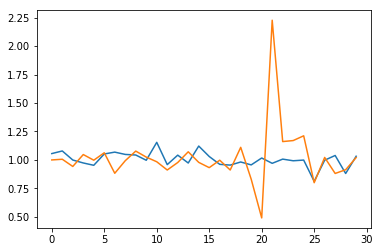

In [67]:
plt.plot(pred_df.sort_values('date').reset_index().drop(columns='index')['prediction'])
plt.plot(pred_df.sort_values('date').reset_index().drop(columns='index')['change'])
plt.show()